# Mạng nơ-ron

Mạng nơ-ron được xây dựng dựa trên ý tưởng mô phỏng lại cách hoạt động của bộ não con người. 
- Mỗi nơ-ron nhận tín hiệu truyền vào, xử lý tín hiệu và tiếp tục gửi tín hiệu đến nơ-ron kế tiếp cho đến khi tín hiệu được xử lý hoàn tất (forward). 
- Sau đó, thông tin về việc xử lý tín hiệu được truyền ngược lại thông qua một cung phản xạ đến nơ-ron phát tín hiệu ban đầu (backward).

Một mạng nơ-ron bắt buộc phải có một tầng đầu vào và một tầng đầu ra. Các tầng ẩn có thể có hoặc không.

<img src="multi_layers.png" style="width:50%; text-align:center">

Trên đây là một hình vẽ mô tả mạng nơ-ron đầy đủ với tầng đầu vào (`input`), 2 tầng ẩn (`hidden layer`) và tầng đầu ra (`output`). `W` là các trọng số dùng để biến đổi tín hiệu truyền từ nơ-ron này sang nơ-ron khác (hay từ lớp này sang lớp khác).

Trong bài học này, chúng ta sẽ làm quen với cách xây dựng một mô hình mạng nơ-ron nhân tạo sử dụng thư viện **Keras**.

# Import dữ liệu

In [1]:
# Import một số thư viện cần thiết.
import random
import numpy as np
import matplotlib.pyplot as plt
import keras

# Sử dụng một mẹo nhỏ để vẽ hình trên cùng một dòng thay vì mở cửa sổ mới
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # đặt kích thước mặc định cho hình
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Một mẹo nhỏ để notebook tự load lại các module bên ngoài;
# xem thêm tại http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Tải dữ liệu Cifar10 từ Keras và chia thành dữ liệu huấn luyện và kiểm tra.
from keras.datasets import cifar10

# Dữ liệu CIFAR10 gồm 50,000 ảnh màu kích thước 32x32 để huấn luyện, gồm 10 chuyên mục, và 10,000 ảnh kiểm tra.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


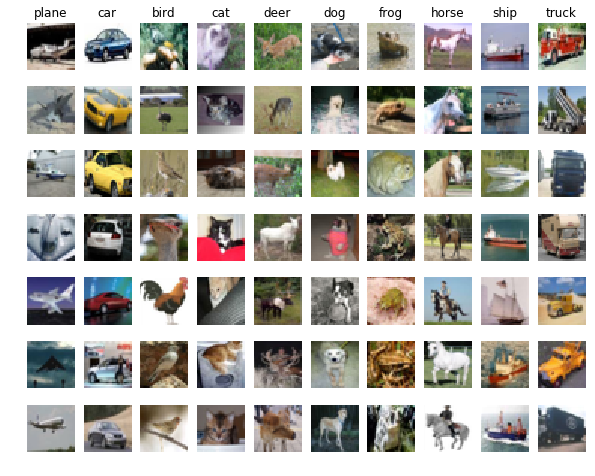

In [3]:
# Hiển thị một số ảnh từ trong bộ dữ liệu.
# Với mỗi lớp, chúng ta sẽ hiển thị một số ảnh minh họa.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Lấy 1 phần nhỏ dữ liệu để huấn luyện hiệu quả hơn trong bài tập này
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# # Định dạng lại hình ảnh thành các hàng
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# Xây dựng mô hình với Keras

**Keras** là một API mạng nơ-ron bậc cao, viết bằng ngôn ngữ Python và có thể chạy trên nền của `Tensorflow`, `CNTK` hay `Theano`.  `Keras` được phát triển với trọng tâm là cho phép người phát triển xây dựng những thử nghiệm nhanh chóng, đi từ ý tưởng đến kết quả với ít chậm trễ nhất.

Cấu trúc dữ liệu cốt lõi của **Keras** là mô hình, cách để tổ chức các lớp. 

Để xây dựng một mô hình trong **Keras**, ta có 2 cách:
- Xây dụng mô hình tuần tự (Sequential model) *hoặc*
- Xây dựng API chức năng (Functional API)

## Mô hình tuần tự
**Mô hình tuần tự** là loại mô hình đơn giản nhất trong **Keras**, là một ngăn xếp tuyến tính các lớp. Để xây dựng mô hình tuần tự, ta thêm lần lượt các lớp theo thứ tự vào trong mô hình.

In [6]:
# import mô hình tuần tự từ thư viện Keras
from keras.models import Sequential

# khởi tạo biến model là một ngăn xếp chứa các lớp
model = Sequential()

### Dense
**Dense** được sử dụng để cài đặt biểu thức **output = activation(dot(input, kernel) + bias)**

Trong đó:
- **activation** là hàm kích hoạt trong một nơ-ron (một lớp), được truyền qua tham số **activation**;
- **kernel** là ma trận trọng số của từng lớp;
- **bias** là véc-tơ sai số của từng lớp.

Tìm hiểu thêm về **Dense** tại [đây](https://keras.io/layers/core/#dense)

In [7]:
# import Dense để tạo ra các lớp trong ngăn xếp model
from keras.layers import Dense

# sử dụng hàm add() để thêm lớp vào trong ngăn xếp
# Tham số:
#    - input_shape hay input_dim: thể hiện kích thước hay số chiều của dữ liệu đầu vào
#    - units: số chiều của dữ liệu tại đầu ra của lớp hiện thời
#    - activation (optional): hàm kích hoạt được sử dụng trong lớp (mặc định là hàm tuyến tính: a(x) = x)

# lấy kích thước của dữ liệu đầu vào
# input_dim: số chiều của mỗi dữ liệu
input_dim = X_train.shape[1]

# input_shape gồm số lượng dữ liệu và số chiều của mỗi dữ liệu
input_shape = X_train.shape

# lớp đầu vào có đầu ra dữ liệu là 64 và không sử dụng hàm kích hoạt
model.add(Dense(units=1024, input_dim=input_dim))


### Hàm kích hoạt (Activation)
**Hàm kích hoạt** được sử dụng để biến đổi tín hiệu đầu vào của một nơ-ron thành tín hiệu đầu ra phù hợp để tiếp tục truyền đi đến nơ-ron tiếp theo.

Ta có thể truyền hàm kích hoạt vào trong mô hình như một tham số của lớp **Dense** hoặc truyền riêng biệt sử dụng lớp **Activation**.

Một số hàm kích hoạt thường sử dụng trong `Keras`: `sigmoid`, `softmax`, `tanh`, `relu`, `softplus`. Tìm hiểu thêm về các hàm kích hoạt tại [đây](https://keras.io/activations/)


In [8]:
# import lớp Activation
from keras.layers import Activation

# sử dụng hàm add() để thêm lớp Activation vào mô hình 
# (trước đó tầng ẩn đã được thêm vào với hàm model.add(Dense()))
# hàm kích hoạt được sử dụng là sigmoid
model.add(Activation('sigmoid')) 

**Bài tập: ** Cài đặt thêm hai tẩng ẩn và tầng đầu ra vào mô hình với:
- Tầng thứ nhất: số chiều đầu ra là **512** và sử dụng hàm kích hoạt **tanh**;
- Tầng thứ hai: số chiều đầu ra là **128** và sử dụng hàm kích hoạt **relu**.
- Tầng đầu ra: số chiều đầu ra là **1**.

In [9]:
# Code tại đây
model.add(Dense(units=512, input_dim=1024))
model.add(Activation('tanh'))
model.add(Dense(units=128, input_dim=512))
model.add(Activation('relu'))
model.add(Dense(units=1, input_dim=128))

### Biên dịch
Sau khi xây dựng được cấu trúc các lớp trong ngăn xếp, ta cần chỉ ra quá trình học của mô hình thông qua hàm **compile()** trước khi huấn luyện mô hình.

Hàm này nhận 3 tham số quan trọng:
- Bộ tối ưu hóa (**optimizer**). Là một chuỗi xác định bộ tối ưu hóa đã được cài đặt sẵn (chẳng hạn như `rmsprop` hay `adam`) hay một thể hiện của lớp [**Optimizer**](https://keras.io/optimizers/). 
- Hàm mất mát (**loss**). Đây là đối tượng mô hình cần cực tiểu hóa. Nó là một xâu xác định tên hàm mất mát đã được cài đặt (ví dụ `categorical_crossentropy ` hay `mse`), hoặc một đối tượng hàm, chi tiết xem tại [đây.](https://keras.io/losses/)
- Danh sách metric (**metrics**). Trong bài toán phân lớp, ta thường chọn `metrics=['accuracy']`.

Tham khảo thêm tại [đây](https://keras.io/getting-started/sequential-model-guide/#compilation)

In [10]:
# Ví dụ về việc định nghĩa quá trình học của mô hình với
# bộ tối ưu là 'rmsprop', hàm mất mát là 'mse' (mean square error)
# và list metric là 'accuracy' 
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])


**Bài tập:** Biên dịch lại mô hình với hàm mất mát là **hinge**, tối ưu hóa bởi **adam** và trả về danh sách metrics **accuracy**.

In [11]:
# Code tại đây
model.compile(optimizer='adam',
              loss='hinge',
              metrics=['accuracy'])

### Huấn luyện mô hình
Các mô hình của **Keras** được huấn luyện trên các mảng **Numpy** của dữ liệu đầu vào và nhãn. Để huấn luyện một mô hình, cần sử dụng hàm **fit()**.

Một số tham số quan trọng của hàm **fit()**:
- **x**: Dữ liệu huấn luyện dưới dạng mảng numpy;
- **y**: Nhãn dữ liệu tương ứng với dữ liệu huấn luyện (mảng numpy);
- **batch_size**: Số lượng dữ liệu trong mỗi lần cập nhật gradient (kiểu nguyên hoặc `None`). Giá trị mặc định là `32`.
- **epochs**: Số lượng giai đoạn để huấn luyện mô hình (kiểu nguyên).

Tìm hiểu thêm về các hàm liên quan tại [đây](https://keras.io/models/sequential/)

In [17]:
# Huấn luyện mô hình dựa trên dữ liệu huấn luyện X_train, y_train
# Lặp lại quá trình học với epochs=10 và batch_size=32
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
5000/5000 [==============================] - 15s 3ms/step - loss: 10.0334 - acc: 0.0926
Epoch 2/10
5000/5000 [==============================] - 17s 3ms/step - loss: 8.9737 - acc: 0.0974
Epoch 3/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.7436 - acc: 0.1016
Epoch 4/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.6053 - acc: 0.0984
Epoch 5/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.5529 - acc: 0.1040
Epoch 6/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.5466 - acc: 0.1006
Epoch 7/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.5349 - acc: 0.1020
Epoch 8/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.5093 - acc: 0.0986
Epoch 9/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.4512 - acc: 0.0992
Epoch 10/10
5000/5000 [==============================] - 17s 3ms/step - loss: 8.5101 - acc: 0.1016


Hàm **fit()** trả về **History** lưu lại lịch sử cập nhật của mô hình. Ta có thể vẽ lại được sự thay đổi của mô hình dựa trên thuộc tính **History.history**, nó lưu lại các giá trị hàm mất mát (`loss`) và giá trị metric tương ứng (`acc`) qua mỗi giai đoạn.

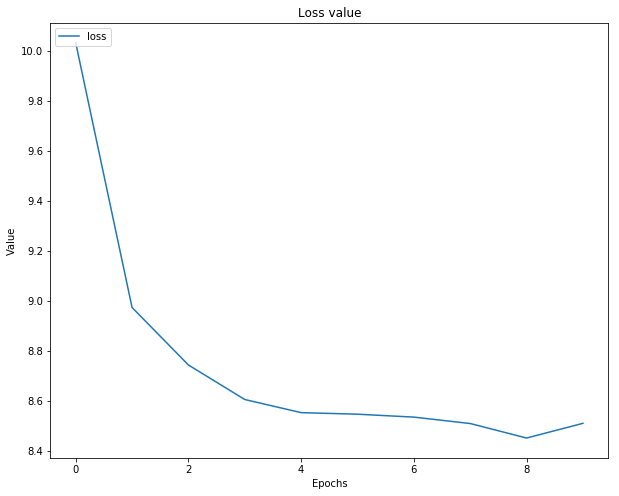

In [18]:
# Xây dựng biểu đồ thể hiện lịch sử thay đổi của mô hình qua mỗi giai đoạn
plt.plot(history.history['loss'])
plt.title("Loss value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(['loss'], loc='upper left')
plt.show()

 
**Bài tập:** Huấn luyện lại mô hình với số epochs là **100** và batch_size bằng **64**. Sử dụng một biến để lưu lại giá trị trả về của hàm **fit()**, dựa vào đó, vẽ lại biểu đồ sự thay đổi của metric qua các giai đoạn.  

In [19]:
# Code ở đây
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

plt.plot(history.history['loss'])
plt.title("Loss value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(['loss'], loc='upper left')
plt.show()

### Dự đoán

Sau khi huấn luyện, mô hình được đánh giá với dữ liệu kiểm tra bằng hàm **evaluate()**.

Hàm nhận 3 tham số quan trọng lần lượt là:
- **x**: Dữ liệu kiểm tra (kiểu mảng Numpy);
- **y**: Nhãn tương ứng với dữ liệu kiểm tra (kiểu mảng Numpy);
- **batch_size**: Số lượng ví dụ được dùng trong mỗi lần cập nhật gradient (kiểu nguyên). Mặc định là **32**.

Hàm trả về một mảng số thực **score** chứa giá trị hàm mất mát (**loss**) và giá trị metric (**accuracy**). Nếu mô hình không có metric, **score** là giá trị mất mát.

In [20]:
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)

500/500 [==============================] - 0s 656us/step
[8.7151197052001947, 0.080000000000000002]


## API chức năng
**API chức năng** là lựa chọn tối ưu trong việc xây dựng mạng kết nối với mật độ cao (các lớp không liên kết tuần tự trong ngăn xếp).

Các lớp có thể đồng thời là đầu vào của nhiều lớp kế tiếp, bằng cách sử dụng đầu ra của lớp đó như một tham số truyền vào của một hàm của lớp khác.

Xây dựng một mô hình với **API chức năng** về cơ bản giống với xây dựng **mô hình tuần tự**. Điều khác nhau duy nhất là quá trình xây dựng cấu trúc các lớp.

In [21]:
# import thêm lớp Input để khởi tạo mô hình
from keras.layers import Input
from keras.models import Model

# khởi tạo một thể hiện của lớp Input
# tham số shape (kiểu tuple) là kích thước của dữ liệu đầu vào (số chiều dữ liệu)
# giá trị trả về là một tensor
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))

# mỗi thể hiện của một lớp có thể được gọi bởi một tensor
# và kết quả trả về là một tensor
# thêm một tầng ẩn gọi đến tensor inputs
x = Dense(64, activation="sigmoid")(inputs)

# ... có thể thêm nhiều tầng ẩn ở giữa ...

# tầng đầu ra của mô hình với số chiều 1
predictions = Dense(1)(x)

# Tạo ra mô hình mới bao gồm tầng đầu vào và các tầng ẩn (kết thúc bằng tensor predictions)
api_model = Model(inputs=inputs, outputs=predictions)

Phần còn lại của quá trình xây dựng **API chức năng** tương tự như **Mô hình tuần tự**.

Tham khảo thêm tại [đây](https://keras.io/getting-started/functional-api-guide/)

**Bài tập:** Tiếp tục hoàn thiện quá trình xây dụng **API chức năng** (biên dịch và huấn luyện mô hình). Sử dụng kết quả **History** trong quá trình huấn luyện để vẽ ra đồ thị thay đổi của giá trị mất mát trong các giai đoạn.

Epoch 1/10
5000/5000 [==============================] - 19s 4ms/step - loss: 8.4975 - acc: 0.0990
Epoch 2/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.4133 - acc: 0.1008
Epoch 3/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.4039 - acc: 0.0992
Epoch 4/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.4053 - acc: 0.0940
Epoch 5/10
5000/5000 [==============================] - 14s 3ms/step - loss: 8.3884 - acc: 0.1042
Epoch 6/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.3529 - acc: 0.1026
Epoch 7/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.4009 - acc: 0.1032
Epoch 8/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.3343 - acc: 0.1014
Epoch 9/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.3415 - acc: 0.1008: 2s 
Epoch 10/10
5000/5000 [==============================] - 15s 3ms/step - loss: 8.3588 - acc: 0.1028


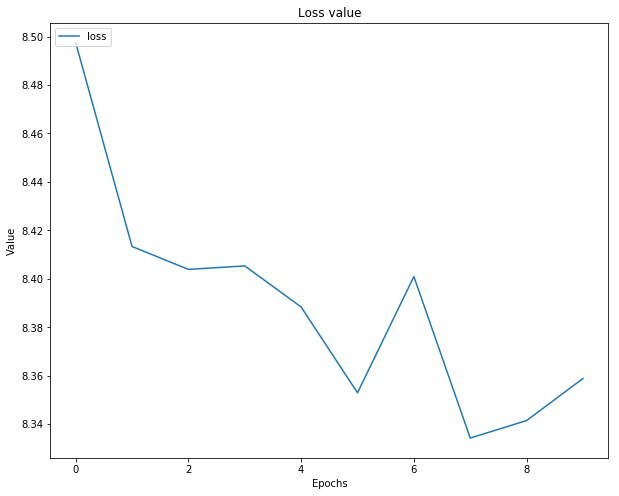

In [22]:
# Code ở đây
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Vẽ
plt.plot(history.history['loss'])
plt.title("Loss value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(['loss'], loc='upper left')
plt.show()

In [23]:
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)

500/500 [==============================] - 1s 2ms/step
[8.6988335647583011, 0.096000000000000002]


### Bài tập
Xây dựng mô hình (bằng **API chức năng** hoặc **Mô hình tuần tự**) sao cho hiệu năng (`acc`) trên tập kiểm tra đạt trên 15%.

Train on 4750 samples, validate on 250 samples
Epoch 1/1000
4750/4750 [==============================] - 2s 322us/step - loss: 14.3630 - acc: 0.1019 - val_loss: 14.3284 - val_acc: 0.1000
Epoch 2/1000
4750/4750 [==============================] - 0s 66us/step - loss: 14.3942 - acc: 0.1025 - val_loss: 14.3200 - val_acc: 0.1000
Epoch 3/1000
4750/4750 [==============================] - 0s 63us/step - loss: 14.3106 - acc: 0.1055 - val_loss: 14.4034 - val_acc: 0.1040
Epoch 4/1000
4750/4750 [==============================] - 0s 66us/step - loss: 14.2569 - acc: 0.1074 - val_loss: 14.3920 - val_acc: 0.1040
Epoch 5/1000
4750/4750 [==============================] - 0s 63us/step - loss: 14.2408 - acc: 0.1101 - val_loss: 14.3853 - val_acc: 0.1040
Epoch 6/1000
4750/4750 [==============================] - 0s 72us/step - loss: 14.2249 - acc: 0.1109 - val_loss: 14.3795 - val_acc: 0.1040
Epoch 7/1000
4750/4750 [==============================] - 0s 66us/step - loss: 14.2120 - acc: 0.1114 - val_loss: 14.36

4750/4750 [==============================] - 0s 69us/step - loss: 13.9096 - acc: 0.1265 - val_loss: 14.0826 - val_acc: 0.1200
Epoch 118/1000
4750/4750 [==============================] - 0s 69us/step - loss: 13.9090 - acc: 0.1265 - val_loss: 14.0826 - val_acc: 0.1200
Epoch 119/1000
4750/4750 [==============================] - 0s 72us/step - loss: 13.9082 - acc: 0.1265 - val_loss: 14.0826 - val_acc: 0.1200
Epoch 120/1000
4750/4750 [==============================] - 0s 66us/step - loss: 13.9076 - acc: 0.1267 - val_loss: 14.0825 - val_acc: 0.1200
Epoch 121/1000
4750/4750 [==============================] - 0s 66us/step - loss: 13.9069 - acc: 0.1267 - val_loss: 14.0826 - val_acc: 0.1200
Epoch 122/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.9063 - acc: 0.1265 - val_loss: 14.0826 - val_acc: 0.1200
Epoch 123/1000
4750/4750 [==============================] - 0s 63us/step - loss: 13.9057 - acc: 0.1267 - val_loss: 14.0826 - val_acc: 0.1200
Epoch 124/1000
4750/4750 [==

Epoch 233/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8671 - acc: 0.1295 - val_loss: 14.0856 - val_acc: 0.1200
Epoch 234/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8669 - acc: 0.1295 - val_loss: 14.0857 - val_acc: 0.1200
Epoch 235/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8667 - acc: 0.1297 - val_loss: 14.0857 - val_acc: 0.1200
Epoch 236/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8665 - acc: 0.1295 - val_loss: 14.0857 - val_acc: 0.1200
Epoch 237/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8663 - acc: 0.1299 - val_loss: 14.0857 - val_acc: 0.1200
Epoch 238/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8661 - acc: 0.1299 - val_loss: 14.0857 - val_acc: 0.1200
Epoch 239/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8659 - acc: 0.1297 - val_loss: 14.0857 - val_acc: 0.1200
Epoch 240/100

Epoch 291/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8567 - acc: 0.1314 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 292/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8565 - acc: 0.1314 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 293/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8564 - acc: 0.1316 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 294/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8562 - acc: 0.1316 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 295/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8561 - acc: 0.1316 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 296/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8559 - acc: 0.1316 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 297/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8558 - acc: 0.1316 - val_loss: 14.0859 - val_acc: 0.1200
Epoch 298/100

4750/4750 [==============================] - 0s 59us/step - loss: 13.8491 - acc: 0.1322 - val_loss: 14.0849 - val_acc: 0.1200
Epoch 350/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8490 - acc: 0.1320 - val_loss: 14.0848 - val_acc: 0.1200
Epoch 351/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8489 - acc: 0.1320 - val_loss: 14.0847 - val_acc: 0.1200
Epoch 352/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8488 - acc: 0.1320 - val_loss: 14.0847 - val_acc: 0.1200
Epoch 353/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8487 - acc: 0.1320 - val_loss: 14.0847 - val_acc: 0.1200
Epoch 354/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8485 - acc: 0.1320 - val_loss: 14.0846 - val_acc: 0.1200
Epoch 355/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8484 - acc: 0.1320 - val_loss: 14.0845 - val_acc: 0.1200
Epoch 356/1000
4750/4750 [==

4750/4750 [==============================] - 0s 63us/step - loss: 13.8380 - acc: 0.1324 - val_loss: 14.0806 - val_acc: 0.1200
Epoch 466/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8380 - acc: 0.1324 - val_loss: 14.0807 - val_acc: 0.1200
Epoch 467/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8379 - acc: 0.1326 - val_loss: 14.0806 - val_acc: 0.1200
Epoch 468/1000
4750/4750 [==============================] - 0s 63us/step - loss: 13.8378 - acc: 0.1324 - val_loss: 14.0806 - val_acc: 0.1200
Epoch 469/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8377 - acc: 0.1324 - val_loss: 14.0806 - val_acc: 0.1200
Epoch 470/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8376 - acc: 0.1324 - val_loss: 14.0806 - val_acc: 0.1200
Epoch 471/1000
4750/4750 [==============================] - 0s 63us/step - loss: 13.8376 - acc: 0.1324 - val_loss: 14.0806 - val_acc: 0.1200
Epoch 472/1000
4750/4750 [==

4750/4750 [==============================] - 0s 59us/step - loss: 13.8306 - acc: 0.1331 - val_loss: 14.0788 - val_acc: 0.1200
Epoch 582/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8305 - acc: 0.1331 - val_loss: 14.0788 - val_acc: 0.1200
Epoch 583/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8305 - acc: 0.1331 - val_loss: 14.0788 - val_acc: 0.1200
Epoch 584/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8304 - acc: 0.1331 - val_loss: 14.0788 - val_acc: 0.1200
Epoch 585/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8304 - acc: 0.1331 - val_loss: 14.0787 - val_acc: 0.1200
Epoch 586/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8303 - acc: 0.1331 - val_loss: 14.0787 - val_acc: 0.1200
Epoch 587/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8302 - acc: 0.1331 - val_loss: 14.0786 - val_acc: 0.1200
Epoch 588/1000
4750/4750 [==

Epoch 639/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8276 - acc: 0.1331 - val_loss: 14.0781 - val_acc: 0.1200
Epoch 640/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8276 - acc: 0.1331 - val_loss: 14.0781 - val_acc: 0.1200
Epoch 641/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8276 - acc: 0.1331 - val_loss: 14.0781 - val_acc: 0.1200
Epoch 642/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8275 - acc: 0.1331 - val_loss: 14.0780 - val_acc: 0.1200
Epoch 643/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8275 - acc: 0.1331 - val_loss: 14.0780 - val_acc: 0.1200
Epoch 644/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8274 - acc: 0.1331 - val_loss: 14.0780 - val_acc: 0.1200
Epoch 645/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8274 - acc: 0.1331 - val_loss: 14.0780 - val_acc: 0.1200
Epoch 646/100

Epoch 697/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8246 - acc: 0.1324 - val_loss: 14.0773 - val_acc: 0.1200
Epoch 698/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8245 - acc: 0.1324 - val_loss: 14.0773 - val_acc: 0.1200
Epoch 699/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8245 - acc: 0.1324 - val_loss: 14.0773 - val_acc: 0.1200
Epoch 700/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8244 - acc: 0.1324 - val_loss: 14.0772 - val_acc: 0.1200
Epoch 701/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8244 - acc: 0.1326 - val_loss: 14.0772 - val_acc: 0.1200
Epoch 702/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8243 - acc: 0.1324 - val_loss: 14.0772 - val_acc: 0.1200
Epoch 703/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8242 - acc: 0.1324 - val_loss: 14.0771 - val_acc: 0.1200
Epoch 704/100

4750/4750 [==============================] - 0s 59us/step - loss: 13.8217 - acc: 0.1333 - val_loss: 14.0766 - val_acc: 0.1200
Epoch 756/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8216 - acc: 0.1333 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 757/1000
4750/4750 [==============================] - 0s 58us/step - loss: 13.8216 - acc: 0.1333 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 758/1000
4750/4750 [==============================] - 0s 57us/step - loss: 13.8215 - acc: 0.1333 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 759/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8215 - acc: 0.1333 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 760/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8215 - acc: 0.1333 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 761/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8214 - acc: 0.1333 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 762/1000
4750/4750 [==

4750/4750 [==============================] - 0s 59us/step - loss: 13.8172 - acc: 0.1341 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 872/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8172 - acc: 0.1341 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 873/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8171 - acc: 0.1341 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 874/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8171 - acc: 0.1341 - val_loss: 14.0766 - val_acc: 0.1200
Epoch 875/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8171 - acc: 0.1341 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 876/1000
4750/4750 [==============================] - 0s 66us/step - loss: 13.8170 - acc: 0.1341 - val_loss: 14.0767 - val_acc: 0.1200
Epoch 877/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8170 - acc: 0.1341 - val_loss: 14.0766 - val_acc: 0.1200
Epoch 878/1000
4750/4750 [==

4750/4750 [==============================] - 0s 59us/step - loss: 13.8135 - acc: 0.1345 - val_loss: 14.0754 - val_acc: 0.1200
Epoch 988/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8135 - acc: 0.1345 - val_loss: 14.0754 - val_acc: 0.1200
Epoch 989/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8135 - acc: 0.1345 - val_loss: 14.0753 - val_acc: 0.1200
Epoch 990/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8135 - acc: 0.1345 - val_loss: 14.0753 - val_acc: 0.1200
Epoch 991/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8134 - acc: 0.1345 - val_loss: 14.0753 - val_acc: 0.1200
Epoch 992/1000
4750/4750 [==============================] - 0s 56us/step - loss: 13.8134 - acc: 0.1345 - val_loss: 14.0753 - val_acc: 0.1200
Epoch 993/1000
4750/4750 [==============================] - 0s 59us/step - loss: 13.8134 - acc: 0.1345 - val_loss: 14.0753 - val_acc: 0.1200
Epoch 994/1000
4750/4750 [==

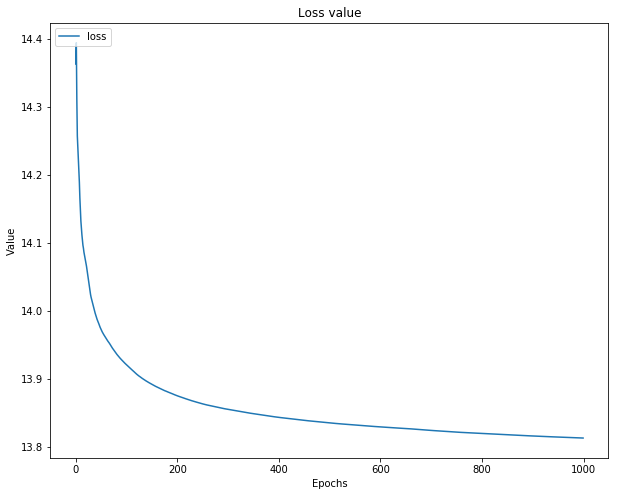

500/500 [==============================] - 0s 125us/step
[13.934299652099609, 0.128]


In [56]:
# Code ở đây
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

input_dim = X_train.shape[1]

# Tạo model
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(50, activation= 'relu', input_dim=input_dim))
model.add(Dense(10  , activation= 'softmax'))

# Compile
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=1e-4, decay=0.95),
             loss='categorical_crossentropy',
             metrics=['accuracy'])



# 
from keras.utils.np_utils import to_categorical   
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)


# Fit
history = model.fit(X_train, y_train, validation_split=0.05, epochs=1000, batch_size=200)

# Vẽ
plt.plot(history.history['loss'])
plt.title("Loss value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(['loss'], loc='upper left')
plt.show()

# Evaluation
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)